# Groupe 3 : Bechet Paul, Cassagne Manon, Labat Valentin, Mirval Mélodie

In [ ]:
import pandas as pd
import warnings

from IPython.core.display import display, HTML 

### options d'affichage
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:95% !important; }</style>")) #permet d'agrandir les cellules

warnings.simplefilter(action='ignore', category=FutureWarning)

# Objectifs

Pour au maximum 0.5% d'anomalies signalées : détecter le maximum de fraude (taux de fraude parmi les anomalies signalées).


# Import des données

Description des données : echantillon de stransactions de cartes de crédit en Europe sur 2 jours.

Variables : issues d'une transformations par Analyse en Composantes Principales (PCA), anonymisées pour des raisons de confidentialités.

#### Base de données des opérations de cartes -> X, Y

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/
import os
path = os.getcwd()
print(path)
repn = os.path.basename(path)
print("Le nom du répertoire est : " + repn)

DATA_PATH = path+'/Projet 3 - Fraud detection/DATA/'

op_carte = pd.read_csv(DATA_PATH+'fraude_carte_dataset.csv')
target = 'fraude'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
/content/drive/My Drive
Le nom du répertoire est : My Drive


In [ ]:
op_carte.head()

,montant,fraude,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,308.00,0,-4.667334,-5.187441,0.604266,-0.028343,2.244867,-0.474571,-1.688557,1.238095,0.706406,-1.358454,-1.169240,-0.058496,-1.451403,0.388620,-0.958128,0.766791,-0.407169,0.555079,0.264348,1.674186,0.411854,-0.969088,0.402915,-1.694552,0.007241,0.852860,-0.128717,-0.687596
1,60.50,0,-0.438869,1.056287,-0.801299,-0.328392,0.540826,-0.698487,0.773505,0.316953,-0.567920,-1.135592,0.565229,0.065585,-0.649158,-0.138078,0.082633,0.396204,0.322093,1.405653,0.267666,-0.094025,0.436785,1.100183,-0.122373,-0.547342,-0.451841,-0.148654,0.084169,0.162065
2,19.45,0,1.226028,0.086071,0.116272,0.041843,-0.387151,-1.081572,0.199786,-0.215388,-0.323449,0.050539,1.675848,1.068217,0.172115,0.538907,0.105433,0.166256,-0.397508,-0.234303,0.297383,-0.028091,-0.006165,-0.049895,-0.033645,0.614550,0.375668,0.976638,-0.105581,-0.009021
3,104.97,0,-1.147631,-0.157931,1.425395,0.054483,0.342307,-1.392831,0.654890,-0.083629,-0.606735,-0.487814,-0.540559,-1.056766,-1.761334,0.770819,1.311843,-0.178690,0.212307,-0.467027,1.167386,0.411067,-0.286517,-1.394336,0.330240,0.348368,-0.059860,0.758528,-0.116141,0.076342
4,54.85,0,1.241569,-0.925653,0.835590,-0.709157,-1.487871,-0.211127,-1.070227,0.160703,-0.539042,0.817164,0.691529,-0.163473,-0.714948,0.212741,0.755791,-0.460059,-0.549690,1.979115,-0.558923,-0.412824,-0.341439,-0.705344,0.087871,-0.004159,-0.119683,0.930542,-0.042786,0.015368


In [ ]:
print('Nombre de fraudes    : {:9.0f}, soit {:2.2%} du total'.format(op_carte[target].sum(),op_carte[target].mean()))
print('Montant frauduleux   : {:9.2f} €, soit {:2.2%} du total'.format(op_carte.query("fraude==1")['montant'].sum(), op_carte.query("fraude==1")['montant'].sum()/op_carte['montant'].sum()))
print('Montant moyen fraude : {:9.2f} €'.format(op_carte.query("fraude==1")['montant'].mean()))
print('Montant moyen        : {:9.2f} €'.format(op_carte['montant'].mean()))

Nombre de fraudes    :       443, soit 0.17% du total
Montant frauduleux   :  56051.72 €, soit 0.25% du total
Montant moyen fraude :    126.53 €
Montant moyen        :     88.39 €


# Echantillonage pour pouvoir évaluer les performances du modèle

In [ ]:
# Importation des fonctions scikit
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Split du dataset en deux datasets, un train et un test
op_carte_train, op_carte_test = sklearn.model_selection.train_test_split(op_carte, test_size=0.1, stratify=op_carte["fraude"])

print('Nombre de fraudes train    : {:9.0f}, soit {:2.2%} du total'.format(op_carte_train["fraude"].sum(),op_carte_train["fraude"].mean()))
print('Nombre de fraudes test     : {:9.0f}, soit {:2.2%} du total'.format(op_carte_test["fraude"].sum(),op_carte_test["fraude"].mean()))
print('Pourcentage fraudes train = Pourcentage fraudes test')
print("Le modèle répartit donc correctement les données en proportions équivalentes")

Nombre de fraudes train    :       399, soit 0.17% du total
Nombre de fraudes test     :        44, soit 0.17% du total
Pourcentage fraudes train = Pourcentage fraudes test
Le modèle répartit donc correctement les données en proportions équivalentes


In [ ]:
# Création de la liste des indices de X
tabstr = ["montant"]
for i in range (1, 29):
  tabstr.append("V" + str(i))

In [ ]:
# Création des X et Y train et test
op_carte_train_fraude = op_carte_train[op_carte_train['fraude'] == 1]
op_carte_train_non_fraude = op_carte_train[op_carte_train['fraude'] == 0]

X_train_fraude = op_carte_train_fraude[tabstr]
Y_train_fraude = op_carte_train_fraude["fraude"]
X_train_non_fraude = op_carte_train_non_fraude[tabstr]
Y_train_non_fraude = op_carte_train_non_fraude["fraude"]

X_test = op_carte_test[tabstr]
Y_test = op_carte_test["fraude"]

# Processing des échantillons 
indice : Normalisation + distinction entre fraudes et non fraudes

In [ ]:
# Normalisation de la donnee
scaler = MinMaxScaler()
X_train_non_fraude_scaled = scaler.fit_transform(X_train_non_fraude)
X_test_scaled = scaler.transform(X_test)

nombre_variables_X = X_test_scaled.shape[1]
print("Il y a ", nombre_variables_X, " variables explicatives.\n")

print("Le X test normalisé devient: \n", X_test_scaled)

Il y a  29  variables explicatives.

Le X test normalisé devient: 
 [[7.97292299e-03 9.31398280e-01 8.09766316e-01 ... 3.72159381e-01
  6.63923844e-01 2.56212596e-01]
 [1.01238621e-03 9.43613396e-01 7.97662841e-01 ... 4.97165809e-01
  6.36388212e-01 2.49890720e-01]
 [9.05551488e-05 9.49564763e-01 8.03783836e-01 ... 4.41133504e-01
  6.57917930e-01 2.59434837e-01]
 ...
 [5.88099731e-04 9.95356838e-01 7.94022267e-01 ... 4.80299941e-01
  6.47380261e-01 2.55075563e-01]
 [1.77549140e-03 9.41721884e-01 8.07687842e-01 ... 3.03591517e-01
  6.40416919e-01 2.53621084e-01]
 [3.48184547e-02 8.84983003e-01 7.82356807e-01 ... 5.57812519e-01
  6.71148806e-01 2.27918380e-01]]


# Modélisation par autoencoder
aussi possible isolationForest

##### Définition et initialisation du modèle

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

class Autoencoder(Model):
    
    def __init__(self, encoder_param_list, decoder_param_list):
        
        # initialisation en tant que Model keras
        super(Autoencoder, self).__init__()

        # couche entrée + encodeur 
        self.encoder_param_list = encoder_param_list
        self.encoder = tf.keras.Sequential(self.encoder_param_list)
        
        # couche décodeur + sortie
        self.decoder_param_list = decoder_param_list
        self.decoder = tf.keras.Sequential(self.decoder_param_list)

    def call(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [ ]:
# Tableau
tab_val=[nombre_variables_X, 20, 17, 14, 11]

# initialisation des couches du réseau de neurone
# Première ligne = codage, deuxième=décodage
autoencoder = Autoencoder([
        tfl.Dense(tab_val[0], activation="relu"), # nombre de neurones = nombre de features (input = x)
        tfl.BatchNormalization(),
        tfl.Dense(tab_val[1], activation="relu"),
        tfl.BatchNormalization(),
        tfl.Dense(tab_val[2], activation="relu"),
        tfl.BatchNormalization(),
        tfl.Dense(tab_val[3], activation="relu"),
        tfl.BatchNormalization(),
        tfl.Dense(tab_val[4], activation="relu")
    ], [
      tfl.Dense(tab_val[4], activation="relu"),
      tfl.BatchNormalization(),
      tfl.Dense(tab_val[3], activation="relu"),
      tfl.BatchNormalization(),
      tfl.Dense(tab_val[2], activation="relu"),
      tfl.BatchNormalization(),
      tfl.Dense(tab_val[1], activation="relu"),
      tfl.BatchNormalization(),
      tfl.Dense(tab_val[0], activation='linear') # nombre de neurones = nombre de features (output = x)
])


# définition de l'optimizer
learning_rate = 3e-4 # learning rate
loss = tf.keras.losses.MSE # définition de la fonction de perte
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss=loss)

In [ ]:
# fit du modèle
epochs = 15
history = autoencoder.fit(
    x=X_train_non_fraude_scaled, y=X_train_non_fraude_scaled, 
    epochs=epochs, 
    batch_size=128,
    validation_split=0.3,
    shuffle=True)

Epoch 1/15
1260/1260 [==============================] - 8s 4ms/step - loss: 0.1882 - val_loss: 0.0074
Epoch 2/15
1260/1260 [==============================] - 6s 5ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 3/15
1260/1260 [==============================] - 6s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/15
1260/1260 [==============================] - 5s 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/15
1260/1260 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/15
1260/1260 [==============================] - 5s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/15
1260/1260 [==============================] - 5s 4ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/15
1260/1260 [==============================] - 5s 4ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/15
1260/1260 [==============================] - 5s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/15
1260/1260 [==============================] - 5s 4ms/step - loss: 0.001

In [ ]:
print("La loss de la fonction diminue bien au fur et à mesure.")

La loss de la fonction diminue bien au fur et à mesure.


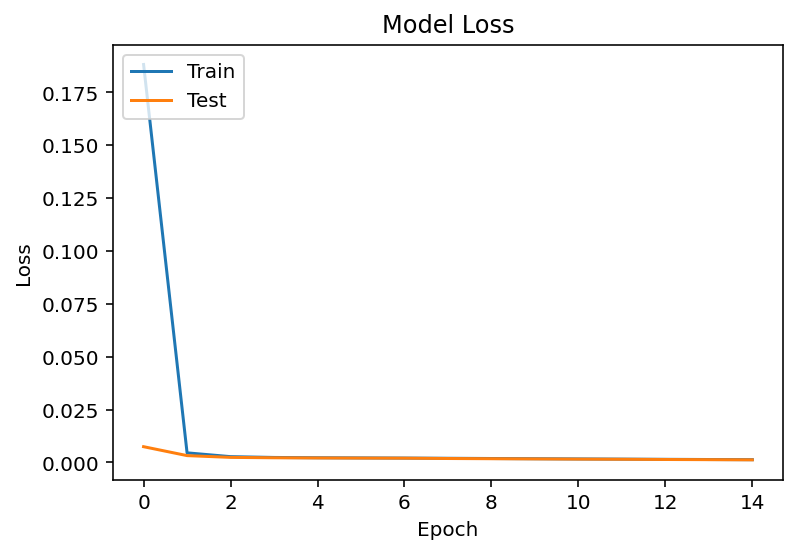

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Évaluation des performances

In [ ]:
import numpy as np

# MSE entre predict et train
score = tf.keras.losses.MSE(X_train_non_fraude_scaled, autoencoder.predict(X_train_non_fraude_scaled))
seuil = np.quantile(score, 0.995)
print("Seuil à partir duquel les opérations sont considérées comme frauduleuses", seuil)

Seuil à partir duquel les opérations sont considérées comme frauduleuses 0.007153676880989226


In [ ]:
# MSE entre predict et test
score_test = tf.keras.losses.MSE(X_test_scaled, autoencoder.predict(X_test_scaled))

is_fraude = score_test > seuil
fraudes_detectees_modele = np.sum(is_fraude == True)
nombre_donnees_test = X_test_scaled.shape[0]

print('Nombre de fraudes détectées par le modèle : ', fraudes_detectees_modele)
print('Nombre total de données : ', nombre_donnees_test)
print('Nombre de fraudes réelles dans le jeu de données : ', Y_test.sum())
proportion = fraudes_detectees_modele / nombre_donnees_test * 100
print('On voit que trop de fraudes sont détectées, cependant cela représente une proportion minime de toutes les données,\n avec ', proportion, "%")
print("Il faut maintenant regarder si les données détectées comme fraudes le sont réellement")

Nombre de fraudes détectées par le modèle :  171
Nombre total de données :  25633
Nombre de fraudes réelles dans le jeu de données :  44
On voit que trop de fraudes sont détectées, cependant cela représente une proportion minime de toutes les données,
 avec  0.6671088050559825 %
Il faut maintenant regarder si les données détectées comme fraudes le sont réellement


In [ ]:
# Calcul des fraudes bien détectées
calcul_part_fraudes_justes = np.array(Y_test)[is_fraude].sum()/Y_test.sum() * 100
print('Part des fraudes détectées à raison : ', calcul_part_fraudes_justes, "%")
print('Pour ces paramètres, nous avons au maximum trouvé un résultat à plus de 86%. \n Celui-ci varie en général entre 70 et 86%. \n Ici, nous avons 77,27%, ce qui est très intéressant\n Le modèle détecte donc une grande majorité des fraudes')

Part des fraudes détectées à raison :  77.27272727272727 %
Pour ces paramètres, nous avons au maximum trouvé un résultat à plus de 86%. 
 Celui-ci varie en général entre 70 et 86%. 
 Ici, nous avons 77,27%, ce qui est très intéressant
 Le modèle détecte donc une grande majorité des fraudes


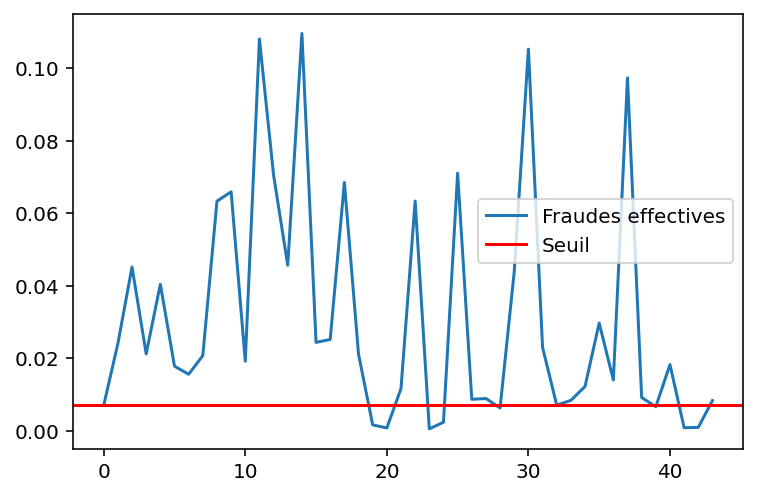

Les fraudes en dessous de la ligne rouge sont celles qui n'ont pas été détectées
On voit que, pour la grande majorité d'entre elles, elles sont très proches de 0
Une diminution de seuil ne serait alors pas très utile, car en le diminuant autant,
on détecterait beaucoup de fraudes dans les opérations non frauduleuses


In [ ]:
from matplotlib import pyplot as plt
indexes = list(Y_test.to_frame().query("fraude==1").index)

liste_Y = list(Y_test)

tab = []
for i in range(len(liste_Y)):
  if (liste_Y[i] == 1):
    tab.append(i)

plt.plot([score_test[i] for i in tab], label="Fraudes effectives")
plt.axhline(seuil, color="red", label="Seuil")
plt.legend()
plt.show()
print("Les fraudes en dessous de la ligne rouge sont celles qui n'ont pas été détectées")
print("On voit que, pour la grande majorité d'entre elles, elles sont très proches de 0")
print("Une diminution de seuil ne serait alors pas très utile, car en le diminuant autant,\non détecterait beaucoup de fraudes dans les opérations non frauduleuses")

# Rendu : application sur de nouvelles opérations de carte
###### Attention ne pas mélanger les index pour le rendu

In [ ]:
testset = pd.read_csv(DATA_PATH+'nouvelle_operation_carte.csv')

In [ ]:
testset.head()

,montant,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,11.74,-0.160291,0.719554,-0.175820,0.092895,1.921963,-0.959215,1.575203,-0.475203,-1.056475,0.018977,0.668056,0.623444,0.250816,0.578553,-0.910825,-0.265297,-0.996237,0.145621,-0.253985,-0.005258,0.211840,0.694953,-0.344278,-0.387714,0.379300,-0.562998,-0.141264,-0.193787
1,0.76,-4.985269,5.034234,-2.823307,2.391830,0.785421,2.062412,-4.029547,-12.755012,-2.319156,0.707228,-1.577851,1.128587,0.137280,1.869368,-1.567146,1.033760,-0.184925,-0.504539,-2.458706,1.777009,-2.657041,1.706531,1.288181,0.496029,-0.453828,-0.222623,-1.005641,-0.522457
2,2.68,2.031150,-0.200373,-1.206788,0.227156,0.007489,-0.641813,-0.012706,-0.079257,0.467886,0.265772,0.528194,0.458737,-1.057644,0.675252,-0.469253,0.179725,-0.539504,-0.222000,0.494652,-0.277039,-0.265289,-0.713294,0.306200,-0.425340,-0.336949,0.207533,-0.079106,-0.076194
3,1.78,-0.182122,0.815268,0.255585,-0.580498,0.530306,-1.078000,0.983743,-0.235750,-0.020917,-0.313036,-0.809413,0.338677,0.354422,0.011465,-0.378042,-0.175447,-0.381779,-0.882839,-0.143792,-0.058797,-0.242450,-0.509106,0.189365,-0.013782,-0.476530,0.134255,0.133186,0.081669
4,104.00,-1.936753,-0.935021,0.450311,-0.548420,0.665697,-1.292993,0.073156,0.434151,-2.039832,0.001525,0.286682,0.150162,-0.542061,0.993127,-0.885168,-0.847956,-0.594685,1.544665,-1.370550,-0.134499,-0.331726,-1.470149,0.257444,-0.122364,-0.186145,-0.926443,-0.023222,-0.155817


In [ ]:
# Transformation
testset_scaled = scaler.transform(testset)

# MSE entre predict et train
score_testset_scaled = tf.keras.losses.MSE(testset_scaled, autoencoder.predict(testset_scaled))
seuil_testset_scaled = np.quantile(score_testset_scaled, 0.995)
print("Seuil à partir duquel les transactions sont considérées frauduleuses : ", seuil_testset_scaled)

Seuil à partir duquel les transactions sont considérées frauduleuses :  0.008241983875632134


In [ ]:
is_fraude_testset_scaled = score_testset_scaled > seuil_testset_scaled 

print('Nombre de fraudes détectées par le modèle : ', np.sum(is_fraude_testset_scaled == True))
integer_map = map(int, is_fraude_testset_scaled)
integer_list = list(integer_map)

px = pd.DataFrame(integer_list)

# On ajoute les prédictions au Dataframe
testset['Prédiction'] = px

Nombre de fraudes détectées par le modèle :  143


In [ ]:
# Suppression du fichier s'il existe déjà
!rm -r "Projet 3 - Fraud detection/RESULTATS/resultats.csv"

In [ ]:
DATA_PATH_INSERT = path+'/Projet 3 - Fraud detection/RESULTATS/'
testset.to_csv(DATA_PATH_INSERT+'resultats.csv')